In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from catboost import CatBoostClassifier
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#После проведения EDA (блок ниже), написал функцию по предобработке данных для любого датафрейма, тест, трайн или фичи
#Сразу удаляем лишнюю колонку, преобразуем дату и переводи в int нужные признаки (например target и vas_id)
def prepare_data(data_df, columns_to_int=None):
    data_df['buy_time'] = pd.to_datetime(data_df['buy_time'], unit='s')
    try:
        data_df = data_df.drop(columns='Unnamed: 0')
    except KeyError:
        pass
    if columns_to_int:
        try:
            data_df[columns_to_int] = data_df[columns_to_int].astype('int64')
        except KeyError:
            raise KeyError("Column doesn't exist, or isn't numeric type. Unable to convert type to int. Correct key mistakes, and try again")
    return data_df

### Загрузка и просмотр датасета

In [3]:
#Убираем фиктивные колонки, видимо индексы, преобразуем даты, чтобы увидеть больше информации из имеющихся данных
df_train = pd.read_csv('data_train.csv')
df_train = prepare_data(df_train, columns_to_int=['vas_id', 'target'])
df_test = pd.read_csv('data_test.csv')
df_test = prepare_data(df_test, columns_to_int='vas_id')
df_train

,id,vas_id,buy_time,target
0,540968,8,2018-09-16 21:00:00,0
1,1454121,4,2018-07-15 21:00:00,0
2,2458816,1,2018-08-12 21:00:00,0
3,3535012,5,2018-09-02 21:00:00,0
4,1693214,1,2018-09-02 21:00:00,0
...,...,...,...,...
831648,3812226,2,2018-12-30 21:00:00,0
831649,2480469,2,2018-12-30 21:00:00,0
831650,158236,2,2018-12-30 21:00:00,0
831651,1825525,2,2018-12-30 21:00:00,0


In [4]:
df_test

,id,vas_id,buy_time
0,3130519,2,2019-01-20 21:00:00
1,2000860,4,2019-01-20 21:00:00
2,1099444,2,2019-01-06 21:00:00
3,1343255,5,2019-01-13 21:00:00
4,1277040,2,2019-01-06 21:00:00
...,...,...,...
71226,2502453,5,2019-01-20 21:00:00
71227,1693213,2,2019-01-20 21:00:00
71228,1891350,2,2019-01-20 21:00:00
71229,2437172,2,2019-01-20 21:00:00


In [5]:
%%time
#Датафрейм очень большой, поэтому решил открывать пандасом только n-первых строк от него.
#UPD: Для максимального извлечения данных для обучения на мердж, прогружал 4250000 строк, почти весь датасет, больше в озу не умещается. Из этих данных намерджил 800000 объектов для обучения

#UPD Final: Делим датафрейм features.csv, на 2 почти равные части по ним иннер мерждим, и делаем конкат, в итоге как-бы собирая из 2х частей итоговые данные для тренировки модели. !!!! ЯЧЕЙКА ВЫПОЛНЯЕТСЯ 5-7 МИНУТ У МЕНЯ !!!!

df_features = pd.read_csv('features.csv.zip', sep='\t', engine='c', nrows=2250000)
df_features_half2 = pd.read_csv('features.csv.zip', sep='\t', engine='c', skiprows=[i for i in range(1, 2250000)])
df_features = prepare_data(df_features)
df_features_half2 = prepare_data(df_features_half2)
df_features

CPU times: total: 5min 56s
Wall time: 5min 57s


,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,2018-07-15 21:00:00,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2014722,2018-10-14 21:00:00,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2015199,2018-12-23 21:00:00,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,25.183903,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,2021765,2018-08-12 21:00:00,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,-65.076097,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,2027465,2018-08-05 21:00:00,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,-65.076097,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249995,1910382,2018-09-23 21:00:00,-84.089971,91.410888,-98.030786,106.603202,-103.448246,85.49821,-16.08618,-59.146097,...,1980.626154,2251.229208,-22.996269,10.369552,-80.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
2249996,1910476,2018-12-09 21:00:00,-54.459971,-133.699112,-68.400786,-186.306798,-73.818246,-207.41179,-16.08618,-65.076097,...,-970.373846,-613.770792,-24.996269,-27.630448,-136.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2249997,1910755,2018-09-09 21:00:00,-92.559971,298.190888,96.029214,1120.953202,90.611754,1099.84821,-16.08618,-47.286097,...,-976.373846,-613.770792,-24.996269,-36.630448,-246.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
2249998,1910965,2018-09-30 21:00:00,-96.799971,-408.179112,-110.740786,-460.786798,-116.158246,-481.89179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0


### 1. EDA (Explore Data Analysis)

In [6]:
df_features.describe()

,id,0,1,2,3,4,5,6,7,8,...,243,244,245,246,247,248,249,250,251,252
count,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,...,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06,2.250000e+06
mean,2.180632e+06,1.384095e-01,2.066754e-01,1.381051e-01,2.373670e-01,9.748741e-02,1.731523e-01,1.196795e-02,9.017393e-02,-3.833907e-02,...,-1.287198e+00,-7.467148e-01,1.003456e-01,-7.150350e-02,-7.049370e-01,-1.088263e-01,8.301778e-04,-8.262202e-03,1.043671e-03,2.555022e-01
std,1.260652e+06,1.946273e+02,4.071594e+02,2.097158e+02,4.791540e+02,2.263798e+02,5.422711e+02,1.078153e+02,2.737020e+02,7.412283e+01,...,3.200340e+03,2.236044e+03,1.062988e+03,2.959711e+02,1.329342e+03,2.518386e+02,1.661549e+01,1.748434e+02,8.229370e+00,8.337374e-01
min,3.000000e+00,-1.376470e+03,-1.494609e+03,-1.379881e+03,-1.331817e+03,-1.385638e+03,-2.009132e+03,-5.830362e+02,-8.023561e+02,-5.737337e+02,...,-9.773738e+02,-6.137708e+02,-2.599627e+01,-3.763045e+01,-3.067477e+02,-2.583289e+01,-6.944285e-01,-1.217593e+01,-4.561399e-01,0.000000e+00
25%,1.088280e+06,-9.679997e+01,-2.090291e+02,-1.107408e+02,-2.429968e+02,-1.161582e+02,-2.600218e+02,-1.608618e+01,-6.507610e+01,-6.783660e+00,...,-9.773738e+02,-6.137708e+02,-2.599627e+01,-3.763045e+01,-3.057477e+02,-2.583289e+01,-6.944285e-01,-1.217593e+01,-4.561399e-01,0.000000e+00
50%,2.178391e+06,-8.493997e+01,-6.071911e+01,-8.531079e+01,-7.942680e+01,-8.768825e+01,-9.353679e+01,-1.608618e+01,-6.507610e+01,-6.783660e+00,...,-9.583738e+02,-6.137708e+02,-2.599627e+01,-3.763045e+01,-2.397477e+02,-2.383289e+01,-6.944285e-01,-1.217593e+01,-4.561399e-01,0.000000e+00
75%,3.275414e+06,1.228003e+01,1.180909e+02,2.780921e+01,1.260832e+02,2.959175e+01,1.194582e+02,-1.608618e+01,-5.914610e+01,-6.783660e+00,...,-4.853738e+02,-4.077708e+02,-2.499627e+01,-3.363045e+01,-7.774772e+01,-1.083289e+01,-6.944285e-01,-9.175933e+00,-4.561399e-01,1.000000e+00
max,4.362734e+06,4.473950e+04,1.034994e+05,4.476064e+04,1.309629e+05,4.712013e+04,1.309418e+05,4.482021e+04,1.032552e+05,4.482952e+04,...,2.876716e+05,1.904692e+05,9.801580e+05,5.429037e+04,2.715813e+05,9.750017e+04,1.892331e+04,9.750782e+04,9.489544e+03,4.460000e+02


In [7]:
#Смотрим на число уникальных значений признака. Вероятно если одно значание - признак бесполезен, его можно выбросить
df_features.nunique().sort_values()

139          1
75           1
81           1
203          1
85           1
        ...   
117    1317474
207    1343057
38     1465830
116    1548854
id     2213001
Length: 255, dtype: int64

In [8]:
#Смотрю Null. Они отсутствуют везде, значит их не нужно обрабатывать
df_features.isna().sum()

id          0
buy_time    0
0           0
1           0
2           0
           ..
248         0
249         0
250         0
251         0
252         0
Length: 255, dtype: int64

In [9]:
df_train.isna().sum()

id          0
vas_id      0
buy_time    0
target      0
dtype: int64

In [10]:
df_test.isna().sum()

id          0
vas_id      0
buy_time    0
dtype: int64

In [11]:
#Смотрю даты
df_features['buy_time'].unique()

array(['2018-07-15T21:00:00.000000000', '2018-10-14T21:00:00.000000000',
       '2018-12-23T21:00:00.000000000', '2018-08-12T21:00:00.000000000',
       '2018-08-05T21:00:00.000000000', '2018-12-16T21:00:00.000000000',
       '2018-09-23T21:00:00.000000000', '2018-12-09T21:00:00.000000000',
       '2018-09-09T21:00:00.000000000', '2018-08-26T21:00:00.000000000',
       '2018-08-19T21:00:00.000000000', '2018-11-18T21:00:00.000000000',
       '2018-10-28T21:00:00.000000000', '2018-10-21T21:00:00.000000000',
       '2018-11-04T21:00:00.000000000', '2018-09-16T21:00:00.000000000',
       '2018-07-08T21:00:00.000000000', '2018-09-30T21:00:00.000000000',
       '2018-07-22T21:00:00.000000000', '2018-12-30T21:00:00.000000000',
       '2018-09-02T21:00:00.000000000', '2018-10-07T21:00:00.000000000',
       '2019-01-13T21:00:00.000000000', '2018-12-02T21:00:00.000000000',
       '2019-01-20T21:00:00.000000000', '2018-11-11T21:00:00.000000000',
       '2018-07-29T21:00:00.000000000', '2019-01-06

In [12]:
#Смотрю время теста, сортируя
test_time = sorted(df_test['buy_time'].unique())
test_time

[numpy.datetime64('2019-01-06T21:00:00.000000000'),
 numpy.datetime64('2019-01-13T21:00:00.000000000'),
 numpy.datetime64('2019-01-20T21:00:00.000000000')]

In [13]:
#Смотрю время трейна, сортируя
#Видно, что на трейн уходит 6 месяцев, а на тест один. Также видно что даты в трейн/тест и у фичей совершенно одинаковые. Это значит что можно мержить фичи в трейн/тест по паре id + дата, т.к пара id и дата полностью описывают параметры пользователей
train_time = sorted(df_train['buy_time'].unique())
train_time

[numpy.datetime64('2018-07-08T21:00:00.000000000'),
 numpy.datetime64('2018-07-15T21:00:00.000000000'),
 numpy.datetime64('2018-07-22T21:00:00.000000000'),
 numpy.datetime64('2018-07-29T21:00:00.000000000'),
 numpy.datetime64('2018-08-05T21:00:00.000000000'),
 numpy.datetime64('2018-08-12T21:00:00.000000000'),
 numpy.datetime64('2018-08-19T21:00:00.000000000'),
 numpy.datetime64('2018-08-26T21:00:00.000000000'),
 numpy.datetime64('2018-09-02T21:00:00.000000000'),
 numpy.datetime64('2018-09-09T21:00:00.000000000'),
 numpy.datetime64('2018-09-16T21:00:00.000000000'),
 numpy.datetime64('2018-09-23T21:00:00.000000000'),
 numpy.datetime64('2018-09-30T21:00:00.000000000'),
 numpy.datetime64('2018-10-07T21:00:00.000000000'),
 numpy.datetime64('2018-10-14T21:00:00.000000000'),
 numpy.datetime64('2018-10-21T21:00:00.000000000'),
 numpy.datetime64('2018-10-28T21:00:00.000000000'),
 numpy.datetime64('2018-11-04T21:00:00.000000000'),
 numpy.datetime64('2018-11-11T21:00:00.000000000'),
 numpy.datet

In [14]:
feature_time = sorted(df_features['buy_time'].unique())
feature_time

[numpy.datetime64('2018-07-08T21:00:00.000000000'),
 numpy.datetime64('2018-07-15T21:00:00.000000000'),
 numpy.datetime64('2018-07-22T21:00:00.000000000'),
 numpy.datetime64('2018-07-29T21:00:00.000000000'),
 numpy.datetime64('2018-08-05T21:00:00.000000000'),
 numpy.datetime64('2018-08-12T21:00:00.000000000'),
 numpy.datetime64('2018-08-19T21:00:00.000000000'),
 numpy.datetime64('2018-08-26T21:00:00.000000000'),
 numpy.datetime64('2018-09-02T21:00:00.000000000'),
 numpy.datetime64('2018-09-09T21:00:00.000000000'),
 numpy.datetime64('2018-09-16T21:00:00.000000000'),
 numpy.datetime64('2018-09-23T21:00:00.000000000'),
 numpy.datetime64('2018-09-30T21:00:00.000000000'),
 numpy.datetime64('2018-10-07T21:00:00.000000000'),
 numpy.datetime64('2018-10-14T21:00:00.000000000'),
 numpy.datetime64('2018-10-21T21:00:00.000000000'),
 numpy.datetime64('2018-10-28T21:00:00.000000000'),
 numpy.datetime64('2018-11-04T21:00:00.000000000'),
 numpy.datetime64('2018-11-11T21:00:00.000000000'),
 numpy.datet

In [15]:
df_train['vas_id'].unique()

array([8, 4, 1, 5, 2, 7, 6, 9], dtype=int64)

In [16]:
#Видно что услуг всего 9, их надо преобразовать в int
df_test['vas_id'].unique()

array([2, 4, 5, 6, 1, 7, 8, 9], dtype=int64)

In [17]:
#Просмотр баланса классов на тесте
feats_bar = df_train.drop(columns='target')
target = df_train['target']
feats_bar

,id,vas_id,buy_time
0,540968,8,2018-09-16 21:00:00
1,1454121,4,2018-07-15 21:00:00
2,2458816,1,2018-08-12 21:00:00
3,3535012,5,2018-09-02 21:00:00
4,1693214,1,2018-09-02 21:00:00
...,...,...,...
831648,3812226,2,2018-12-30 21:00:00
831649,2480469,2,2018-12-30 21:00:00
831650,158236,2,2018-12-30 21:00:00
831651,1825525,2,2018-12-30 21:00:00


In [18]:
target

0         0
1         0
2         0
3         0
4         0
         ..
831648    0
831649    0
831650    0
831651    0
831652    0
Name: target, Length: 831653, dtype: int64

0    0.927631
1    0.072369
Name: target, dtype: float64

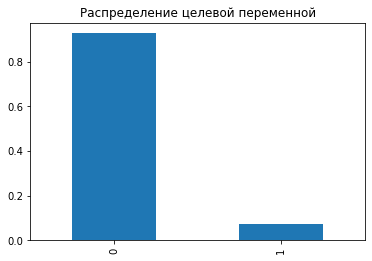

In [19]:
#Очень сильный дизбаланс классов. Возможно во время обучения нужно использовать деревья или мощные ансамбли (LightGBM или CatBoost?)
(target.value_counts()/target.shape[0]).plot(kind='bar', title='Распределение целевой переменной')
target.value_counts()/target.shape

In [20]:
%%time
#Исследвание фичей
features_copy = df_features.copy()
features_copy.set_index('id')
features_copy.drop(columns=['buy_time'], inplace=True)
feature_nunique = features_copy.apply(lambda x: x.nunique(dropna=False))
feature_nunique.shape

CPU times: total: 22 s
Wall time: 22.8 s


(254,)

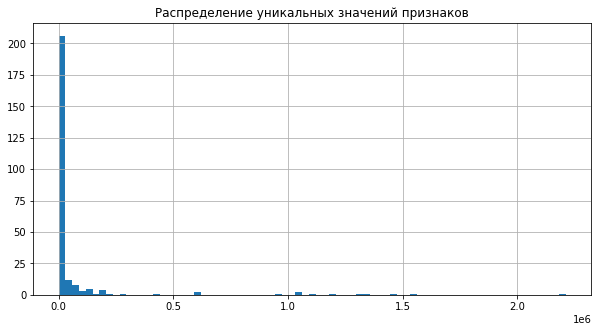

In [21]:
#Распределение значений
plt.title("Распределение уникальных значений признаков")
feature_nunique.hist(bins=75,figsize=(10, 5));

In [22]:
#Все признаки
f_all = set(feature_nunique.index.tolist())
len(f_all)

254

In [23]:
#Константные признаки, подлежат удалению (неиспользованию в обучении модели)
f_const = set(feature_nunique[feature_nunique == 1].index.tolist())
len(f_const)

5

In [24]:
f_const

{'139', '203', '75', '81', '85'}

In [25]:
%%time
#Вещественные признаки
f_numeric = (features_copy.fillna(0).astype(int).sum() - features_copy.fillna(0).sum()).abs()
f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
len(f_numeric)

CPU times: total: 11.6 s
Wall time: 12.2 s


247

In [26]:
f_other = f_all - (f_numeric | f_const)
f_other.add('buy_time')
len(f_other)

3

In [27]:
#Остается 2 признака, id это понятно и 2ой скорее всего бинарный, посмотрим на него
f_other

{'252', 'buy_time', 'id'}

In [28]:
#Видно что целочисленный, можно кидать в предобработку его на целое число, не категория определенно
features_copy['252'].nunique()

60

### Итоги EDA, выводы
1. Отсутствуют Null, id уникальны можно поставить индексом в датафреймах<br/>
2. Признаки с разными уникальными значениями, там где одно уникальное значение - их можно удалить, они не несут никакого смысла<br/>
3. Даты в фичах и в трейн/тест - одинаковые уникальные значения, это хорошо можно сразу мерджить фичи в трейн/тест данные по id + buy_time<br/>
4. Сильный дизбаланс классов, линейные модели вряд ли обучатся хорошо. Нужно использовать ансамбли или случайные леса скорее всего.<br/>
5. Target, vas_id нужно преобразовать в Int<br/>
6. Все признаки у которых уникальные значения в диапазоне от 2 до 30 считаем категориальными на старте<br/>
7. При попадании данных в пайплайн постараться делать сразу 3 действия: buy_time преобразовывать в date_time, делать drop 'Unnamed: 0', делать лефт мердж  по id и buy_time<br/>


UPD: Во второй ячейке написал функцию по первичной предобработке данных, по пункту 7 + сразу преобразовывает в инт указанные колонки<br/>
UPD2: Просмотрел фичи в датасете с фичами, теперь мерджить и писать пайплайны

### 2. Подготовка данных для обучения модели (Feature Engineering)

In [29]:
%%time
#Выбираем признаки для обучения
f_ok = list(f_other | f_numeric)

CPU times: total: 0 ns
Wall time: 0 ns


In [30]:
#Функция выполняется в районе минуты - 2х. 2 больших мерджа и склеивание датасетов до финала
def feature_creator(df_test):
    #Мерджим датафрейм входной с первой частью признаков и переименовываем
    test_feats_half1 = df_test.merge(df_features[f_ok], how='inner', on='id')
    test_feats_half1.rename(columns={'buy_time_x': 'buy_time', 'buy_time_y': 'data_receive_time'}, inplace=True)
    #Мерджим датафрейм входной со второй частью признаков и переименовываем
    test_feats_half2 = df_test.merge(df_features_half2[f_ok], how='inner', on='id')
    test_feats_half2.rename(columns={'buy_time_x': 'buy_time', 'buy_time_y': 'data_receive_time'}, inplace=True)
    #Объединяем в единый сет
    test = pd.concat([test_feats_half1, test_feats_half2], ignore_index=True)
    #Добавляем фичу разницы времени между собранной карточкой абнента и предолжения ему услуги
    test['time_delta(buy_time-receive_time)'] = (pd.to_datetime(test['buy_time']) - pd.to_datetime(test['data_receive_time'])).dt.days.astype('int64')
    #Возвращаем итоговый датафрейм, удаляя дубликаты. Датафрейм получается со всеми готовыми признаками, по которым можно учить модель
    #Преобразование дат, в timestamp обратно, для удобства разбиения на категории и обучения модели
    if test['data_receive_time'].dtype == '<M8[ns]':
        test['data_receive_time'] = test.data_receive_time.values.astype(np.int64) // 10 ** 9
    if test['buy_time'].dtype == '<M8[ns]':
        test['buy_time'] = test.buy_time.values.astype(np.int64) // 10 ** 9
#        X.set_index('id')
    #Преобразования в int, для обучения модели
    test['252'] = test['252'].astype(np.int64)
    return test[~test[['id', 'vas_id', 'buy_time']].duplicated()]

In [31]:
%%time
#Здесь уже создана функция в ячейке 30, которая будет из data_train или data_test, сразу делать готовый датасет для вставки в модель. Функция сделана на основе кода из ячеек

#В этой ячейке проверяется работа функции на тесте, переменная все равно будет перезаписана, ранее заготовленным файлом из ячеек
#df_train_main = feature_creator(df_train)
#df_train_main

CPU times: total: 0 ns
Wall time: 0 ns


In [32]:
#Сохраняем конечный сет для обучения модели, на нем можно сразу учить модель
#df_train_main.to_csv('train.csv')

In [33]:
%%time
#Грузим - проверяем что открывается корректно
df_train_main = pd.read_csv('train.csv', index_col='Unnamed: 0')
df_train_main

CPU times: total: 45.9 s
Wall time: 47.1 s


,id,vas_id,buy_time,target,131,50,252,181,152,93,...,150,134,130,211,108,216,2,229,222,time_delta(buy_time-receive_time)
0,3535012,5,1535922000,0,1.426717,20.869716,0,-1.257363,-0.212646,-0.185299,...,-0.143269,-190.670372,-7.681641,-61786.947098,12.174686,-0.000083,54.079214,-107.128986,-5.726695e+08,28
1,1693214,1,1535922000,0,1.426717,33.869716,0,-1.257363,-0.212646,-0.185299,...,0.296731,-190.670372,8.318359,-61771.833764,191.444686,-0.000083,64.679214,-87.128986,9.708557e+08,-84
2,3173665,8,1532898000,0,1.426717,-45.130284,0,-1.257363,-0.212646,-0.185299,...,-0.143269,-190.670372,-7.681641,-61790.157098,17.694686,-0.000083,-81.090786,-266.128986,-5.726695e+08,-56
3,3577737,5,1545598800,0,1.426717,36.869716,1,-1.257363,-0.212646,-0.185299,...,-0.143269,-190.670372,12.318359,-61790.157098,-11.955314,-0.000083,-110.740786,-235.128986,-5.726695e+08,168
4,2000856,1,1534712400,0,1.426717,151.869716,0,-1.257363,-0.212646,-0.185299,...,0.196731,-190.670372,30.318359,-61494.237098,23.214686,-0.000083,178.619214,-266.128986,9.595373e+08,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860047,1586693,2,1546203600,0,-1.573283,-41.130284,0,-1.257363,-0.212646,-0.185299,...,-0.143269,-190.670372,-8.681641,-61790.157098,-11.955314,-0.000083,-110.740786,-265.128986,-5.726695e+08,28
860048,90279,2,1546203600,0,-3.573283,-37.130284,0,-1.257363,-0.212646,-0.185299,...,-0.143269,-190.670372,-14.681641,-61790.157098,-11.955314,-0.000083,-101.430786,125.871014,9.752621e+08,-14
860049,3812226,2,1546203600,0,1.426717,-35.130284,0,-1.257363,-0.212646,-0.185299,...,-0.143269,-190.670372,1.318359,-61790.157098,112.464686,-0.000083,24.279214,-266.128986,-5.726695e+08,154
860050,158236,2,1546203600,0,-3.573283,-46.130284,0,-1.257363,-0.212646,-0.185299,...,-0.143269,-190.670372,-14.681641,-61790.157098,-11.955314,-0.000083,-110.740786,-95.128986,-5.726695e+08,84


In [34]:
#Попробую замерджить данные из нашего большого трейна в тест, по id и buy_time и смотреть разницу в числе строк, датасета. Количество строк не должно меняться
df_test

,id,vas_id,buy_time
0,3130519,2,2019-01-20 21:00:00
1,2000860,4,2019-01-20 21:00:00
2,1099444,2,2019-01-06 21:00:00
3,1343255,5,2019-01-13 21:00:00
4,1277040,2,2019-01-06 21:00:00
...,...,...,...
71226,2502453,5,2019-01-20 21:00:00
71227,1693213,2,2019-01-20 21:00:00
71228,1891350,2,2019-01-20 21:00:00
71229,2437172,2,2019-01-20 21:00:00


In [35]:
%%time
#Еще раз прогон функции на тесте и число строк полностью сохраняется - теперь смело пихаем в наш пайплайн
#test_main = feature_creator(df_test)
#test_main

CPU times: total: 0 ns
Wall time: 0 ns


### Итоги 2го этапа.
1) Написал функцию по предобработке исходных данных. (Удаление колнки лишней, float_to_int, преобразование из timestamp в datetime)
2) Подготовил из 4250000 объектов с признаками (94.5% всех признаков), ~800000 для обучения модели через мердж трейна и признаков по пользователям
3) Получили 2 даты по каждому пользователю: одна - дата покупки, вторая - дата сбора информации об абоненте. Необходимо будет сделать 3ю фичу разницу этих дат в днях по модулю, она будет отражать актуальность данных об абоненте

###### Дальнейший план работы
1) Загрузить данные из заготовленного файла для трейна 4250k_feats_train.zip в нем csv
2) Перед созданием последней фичи или после, промерджить данные по id/id+buy_time, в data_train.csv. Необходимо убедиться что тест, никак не меняется по объему данных (количеству объектов или хотя бы в не меньшую сторону)
3) Разбить данные на трейн/тест, для измерения метрики. Кросс валидация по ситуации буду думать и по времени, наверное после бейзлайна уже.
4) После создания фичи, можно собирать модель/пайплайн и обучать модель. Затем gridsearch/другие модели, но исходные данные будут уже эти точно
5) Сохранение результатов и все остальные прикладные вещи

UPD: Добавил данные в пункт 2 итогов, до полного количества, собрал 100% данных и добавил фичу разницы дней.
UPD2: Фичи собираю через 2 датафрейма из features.csv, а потом при предсказания теста, нужно делать конкатенацию, чтобы вернуть исходное состояние. В полученном датасете больше строк чем в тесте, т.к id дублируются для разного времени.
UPD3: Решено UPD2, df_test_mod[~df_test_mod[['id', 'vas_id', 'buy_time']].duplicated()], удаляем дубликаты подмножества (id, vas_id, buy_time), получаем исходный датасет. Очень важно при обработке

In [36]:
#f_other.remove('id')
f_other.update(['data_receive_time', 'vas_id'])
f_numeric.add('time_delta(buy_time-receive_time)')
#col_ok = list(f_other | f_numeric)
f_other

{'252', 'buy_time', 'data_receive_time', 'id', 'vas_id'}

In [37]:
df_train_main.isnull().sum()


id                                   0
vas_id                               0
buy_time                             0
target                               0
131                                  0
                                    ..
216                                  0
2                                    0
229                                  0
222                                  0
time_delta(buy_time-receive_time)    0
Length: 254, dtype: int64

In [38]:
y = df_train_main['target']
X = df_train_main.drop(columns='target')
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    test_size=0.30,
                                                    random_state=42)

In [39]:
class FeatureCreator(BaseEstimator, TransformerMixin):
    """
    Transform base data test add them features from subscriber info
    Use only on base test data (data_train that not changed)
    Data train already prepared and doesn't need to change them on fit method
    """
    def __init__(self, key=None):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        #Мерджим датафрейм входной со второй частью признаков и переименовываем, предварительно проверяя чтобы малый датасет был меньше 6 колонок
        if X.shape[1] < 6:
            test_feats_half1 = X.merge(df_features[self.key], how='inner', on='id')
            test_feats_half2 = X.merge(df_features_half2[self.key], how='inner', on='id')
            test_feats_half1.rename(columns={'buy_time_x': 'buy_time', 'buy_time_y': 'data_receive_time'}, inplace=True)
            test_feats_half2.rename(columns={'buy_time_x': 'buy_time', 'buy_time_y': 'data_receive_time'}, inplace=True)
        #Объединяем в единый сет
            X = pd.concat([test_feats_half1, test_feats_half2], ignore_index=True)
        #Добавляем фичу разницы времени между собранной карточкой абнента и предолжения ему услуги
            X['time_delta(buy_time-receive_time)'] = (pd.to_datetime(X['buy_time']) - pd.to_datetime(X['data_receive_time'])).dt.days.astype('int64')
        #Преобразование времени в timestamp, для удобства обучения модели признаков
        if X['data_receive_time'].dtype == '<M8[ns]':
            X['data_receive_time'] = X.data_receive_time.values.astype(np.int64) // 10 ** 9
        if X['buy_time'].dtype == '<M8[ns]':
            X['buy_time'] = X.buy_time.values.astype(np.int64) // 10 ** 9
        #Преобразование категории в целое число
        X['252'] = X['252'].astype('int64')
        #Возвращаем итоговый датафрейм, удаляя дубликаты. Датафрейм получается со всеми готовыми признаками, по которым можно учить модель
        return X[~X[['id', 'vas_id', 'buy_time']].duplicated()]

    #Если во время работы pipeline выходит исключение по различиям размера данных и метки класса, нужно применить сначала этот equalizer и метку класса для трансформированного X, которая сможет нормально обучиться на модели. Это может произойти в случае сжатия дубликатов во время работы pipeline
    def label_len_equalizer(self, X, y):
        X_new = self.transform(X)
        y_new = X_new.join(y)
        try:
            return y_new['target']
        except KeyError:
            raise KeyError("'y' - isn't target label. Put in y argument a target label")

In [40]:
%%time
#Тестируем что создаватель фичей работает на тесте, трейн уже готов сразу, с ним никаких предобработок не надо делать
test_creator = make_pipeline(FeatureCreator(key=f_ok))
tst = test_creator.transform(df_test)
tst

CPU times: total: 53.4 s
Wall time: 2min 4s


,id,vas_id,buy_time,178,181,223,54,100,59,160,...,137,176,138,243,133,24,182,188,186,time_delta(buy_time-receive_time)
0,3130519,2,1548018000,-0.005184,-1.257363,-58.544078,-4.958702,-3.950157,-3.882665,-0.152157,...,-0.825973,-0.033778,-1.935988,-970.373846,0.582717,-0.009327,-2.793637,-23.970371,-53.767387,133
1,2000860,4,1548018000,-0.005184,-1.257363,-58.544078,-4.958702,-3.950157,-2.882665,-0.152157,...,-0.825973,-0.033778,-1.935988,-977.373846,-0.417283,-0.009327,-2.793637,-35.303704,-65.100720,182
2,1343255,5,1547413200,-0.005184,-1.257363,297.385922,-4.958702,-3.950157,-3.882665,-0.152157,...,-0.825973,-0.033778,-1.935988,-977.373846,-0.017283,-0.009327,-2.793637,-21.220371,-2.250720,126
3,3195325,6,1548018000,-0.005184,-1.257363,-58.544078,-4.958702,-3.950157,-3.882665,-0.152157,...,-0.825973,-0.033778,-1.935988,-977.373846,-0.417283,-0.009327,-2.793637,-35.303704,-65.100720,7
4,3324464,1,1547413200,-0.005184,5.742637,43.145922,2.041298,-3.950157,4.117335,-0.152157,...,5.174027,-0.033778,2.064012,-175.373846,-0.017283,-0.009327,5.789697,-34.270371,-37.850722,182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73661,899101,2,1548018000,-0.005184,-1.257363,-58.544078,-4.958702,-3.950157,-0.882665,-0.152157,...,-0.825973,-0.033778,-1.935988,-531.373846,-0.417283,-0.009327,-2.793637,-35.303704,-65.100720,147
73662,3173663,2,1548018000,-0.005184,-1.257363,-58.544078,-4.958702,-3.950157,-2.882665,-0.152157,...,-0.825973,-0.033778,-1.935988,-576.373846,-0.167283,-0.009327,-2.793637,-31.770370,-59.317386,28
73663,2545712,2,1548018000,-0.005184,-1.257363,144.845922,3.041298,-3.950157,-2.882665,0.517843,...,-0.825973,-0.033778,-1.935988,-977.373846,0.582717,-0.009327,-2.793637,61.146296,31.665940,161
73664,1693213,2,1548018000,-0.005184,-1.257363,-58.544078,-4.958702,-3.950157,-3.882665,-0.152157,...,-0.825973,-0.033778,-0.935988,-977.373846,0.582717,-0.009327,-2.793637,-17.487036,-47.284052,70


In [41]:
tst

,id,vas_id,buy_time,178,181,223,54,100,59,160,...,137,176,138,243,133,24,182,188,186,time_delta(buy_time-receive_time)
0,3130519,2,1548018000,-0.005184,-1.257363,-58.544078,-4.958702,-3.950157,-3.882665,-0.152157,...,-0.825973,-0.033778,-1.935988,-970.373846,0.582717,-0.009327,-2.793637,-23.970371,-53.767387,133
1,2000860,4,1548018000,-0.005184,-1.257363,-58.544078,-4.958702,-3.950157,-2.882665,-0.152157,...,-0.825973,-0.033778,-1.935988,-977.373846,-0.417283,-0.009327,-2.793637,-35.303704,-65.100720,182
2,1343255,5,1547413200,-0.005184,-1.257363,297.385922,-4.958702,-3.950157,-3.882665,-0.152157,...,-0.825973,-0.033778,-1.935988,-977.373846,-0.017283,-0.009327,-2.793637,-21.220371,-2.250720,126
3,3195325,6,1548018000,-0.005184,-1.257363,-58.544078,-4.958702,-3.950157,-3.882665,-0.152157,...,-0.825973,-0.033778,-1.935988,-977.373846,-0.417283,-0.009327,-2.793637,-35.303704,-65.100720,7
4,3324464,1,1547413200,-0.005184,5.742637,43.145922,2.041298,-3.950157,4.117335,-0.152157,...,5.174027,-0.033778,2.064012,-175.373846,-0.017283,-0.009327,5.789697,-34.270371,-37.850722,182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73661,899101,2,1548018000,-0.005184,-1.257363,-58.544078,-4.958702,-3.950157,-0.882665,-0.152157,...,-0.825973,-0.033778,-1.935988,-531.373846,-0.417283,-0.009327,-2.793637,-35.303704,-65.100720,147
73662,3173663,2,1548018000,-0.005184,-1.257363,-58.544078,-4.958702,-3.950157,-2.882665,-0.152157,...,-0.825973,-0.033778,-1.935988,-576.373846,-0.167283,-0.009327,-2.793637,-31.770370,-59.317386,28
73663,2545712,2,1548018000,-0.005184,-1.257363,144.845922,3.041298,-3.950157,-2.882665,0.517843,...,-0.825973,-0.033778,-1.935988,-977.373846,0.582717,-0.009327,-2.793637,61.146296,31.665940,161
73664,1693213,2,1548018000,-0.005184,-1.257363,-58.544078,-4.958702,-3.950157,-3.882665,-0.152157,...,-0.825973,-0.033778,-0.935988,-977.373846,0.582717,-0.009327,-2.793637,-17.487036,-47.284052,70


In [42]:
y_train = FeatureCreator(key=f_ok).label_len_equalizer(X_train, y_train)

In [43]:
%%time
frozen_params = {
#      'class_weights':[1, 2.5],
      'silent':False,
      'random_state':42,
      'eval_metric':'F1',
#      'early_stopping_rounds':20
}

main_pipeline = make_pipeline(
    FeatureCreator(key=f_ok),
    CatBoostClassifier(**frozen_params, cat_features=['vas_id'], ignored_features=['id']),
)

main_pipeline.fit(X_train, y_train)

Learning rate set to 0.156173
0:	learn: 0.3717545	total: 558ms	remaining: 9m 17s
1:	learn: 0.2302011	total: 913ms	remaining: 7m 35s
2:	learn: 0.3712303	total: 1.22s	remaining: 6m 46s
3:	learn: 0.3717177	total: 1.51s	remaining: 6m 15s
4:	learn: 0.2283126	total: 1.85s	remaining: 6m 8s
5:	learn: 0.2284121	total: 2.23s	remaining: 6m 9s
6:	learn: 0.2433867	total: 2.59s	remaining: 6m 7s
7:	learn: 0.3699370	total: 2.97s	remaining: 6m 8s
8:	learn: 0.3715422	total: 3.34s	remaining: 6m 7s
9:	learn: 0.3716784	total: 3.73s	remaining: 6m 9s
10:	learn: 0.3715181	total: 4.11s	remaining: 6m 9s
11:	learn: 0.3715437	total: 4.41s	remaining: 6m 2s
12:	learn: 0.3681058	total: 4.79s	remaining: 6m 3s
13:	learn: 0.3680208	total: 5.15s	remaining: 6m 2s
14:	learn: 0.3671461	total: 5.5s	remaining: 6m
15:	learn: 0.3674768	total: 5.81s	remaining: 5m 57s
16:	learn: 0.3661309	total: 6.17s	remaining: 5m 56s
17:	learn: 0.3587344	total: 6.5s	remaining: 5m 54s
18:	learn: 0.3596021	total: 6.82s	remaining: 5m 52s
19:	lear

Pipeline(steps=[('featurecreator',
                 FeatureCreator(key=['178', '181', '223', '54', '100', '59',
                                     '160', '66', '118', '124', '6', '105',
                                     '241', '128', '205', '210', '23', '117',
                                     '5', '43', '134', '238', '109', '166',
                                     '64', '32', '60', '184', '148', '51', ...])),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x0000023C5311EBE0>)])

In [44]:
%%time
y_pred = main_pipeline.predict(X_test)
y_pred

CPU times: total: 1.84 s
Wall time: 2.41 s


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [45]:
%%time
test_predict = main_pipeline.predict(df_test)
test_predict

CPU times: total: 46.5 s
Wall time: 2min 1s


array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [46]:
#Смотрим метрики которые получились, вроде бы и не плохо для начала
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97    231382
           1       0.61      0.31      0.41     18114

    accuracy                           0.94    249496
   macro avg       0.78      0.65      0.69    249496
weighted avg       0.92      0.94      0.93    249496



In [47]:
#Функция построения графика зависимости метрик и порога вероятности
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    figure = plt.figure(figsize = (10, 5))

    plt1 = figure.add_subplot(111)
    plt1.axhline(0.5, color="red")
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))

In [48]:
y_pred_proba = main_pipeline.predict_proba(X_test)
y_pred_proba

array([[0.98806786, 0.01193214],
       [0.79899597, 0.20100403],
       [0.98866823, 0.01133177],
       ...,
       [0.98969673, 0.01030327],
       [0.98578205, 0.01421795],
       [0.99327919, 0.00672081]])

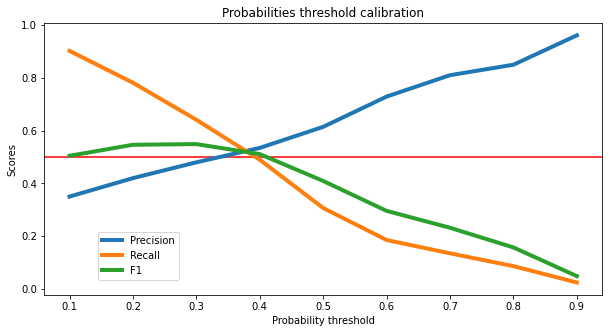

In [49]:
#Строим график распределения вероятности метки классов, к нашим метрика (presicion, recall, F-мера)
show_proba_calibration_plots(y_pred_proba[:, 1], y_test)

In [50]:
#0.25 оптимальный порог. Приоритетнее наверное recall, т.к нам нужно видеть как можно больше потенциальных покупателей, но и precision совсем терять не нужно, чтобы зря не тратили средства из-за "ошибочных" покупателей
#Конечные метрики получаем ниже на базовой модели
print(classification_report(y_test, (y_pred_proba[:, 1] > 0.25)))

              precision    recall  f1-score   support

           0       0.98      0.93      0.95    231382
           1       0.45      0.71      0.55     18114

    accuracy                           0.92    249496
   macro avg       0.71      0.82      0.75    249496
weighted avg       0.94      0.92      0.92    249496



In [51]:
test_predict_proba = main_pipeline.predict_proba(df_test)
test_predict_proba[:, 1]

array([2.10164771e-05, 2.88984600e-01, 3.61794907e-05, ...,
       4.82532440e-05, 2.59702214e-05, 5.15920289e-05])

In [52]:
#Результат формируем и выводим
result_baseline = df_test.copy()
result_baseline['target'] = test_predict_proba[:, 1]
result_baseline

,id,vas_id,buy_time,target
0,3130519,2,2019-01-20 21:00:00,0.000021
1,2000860,4,2019-01-20 21:00:00,0.288985
2,1099444,2,2019-01-06 21:00:00,0.000036
3,1343255,5,2019-01-13 21:00:00,0.324649
4,1277040,2,2019-01-06 21:00:00,0.000040
...,...,...,...,...
71226,2502453,5,2019-01-20 21:00:00,0.000015
71227,1693213,2,2019-01-20 21:00:00,0.000029
71228,1891350,2,2019-01-20 21:00:00,0.000048
71229,2437172,2,2019-01-20 21:00:00,0.000026


In [53]:
#Сохранение результата предсказаний
result_baseline.to_csv('answers_test.csv')

In [54]:
#Сохранение модели
import joblib
joblib.dump(main_pipeline, 'baseline_pipe.pkl')

['baseline_pipe.pkl']

## Итоги

1) Произвел небольшой EDA по признакам, отбирал признаки по значениям. Но в итоге в категории годится только id услуги
2) Большое количество времени было потрачено на обработку данных, и преобразование/проверки типов данных моделей и троблшутов связанных с данными. (Долгие сборки ноутбуков и вопросы с категориальными переменными и данными)
3) Собрал класс FeatureCreator, для пайплайна, чтобы он сразу к любым тестовым данным автоматом присоединял признаки (по частям) делал и присоединял их в соответствии с текущими данными без потери данных (всех), при мердже возникают дубли, дубли устраняются функцией. В пайплайне в результате дублей иногда X и y (данные и метка класса), может не совпадать по числу объектов из-за того что при обработке пайплайна метода transform стирает дубли, в этом случае нужно создать объект класса FeatureCreator отдельно без пайплайна и в метод label_len_equalizer передать X и y (базовые ОДНОЙ РАЗМЕРНОСТИ) метод выдаст новый y (метки с уменьшенной размерностью), которую уже можно класть смело в пайплайн
4) Данные огромны, очень долго проходят мерджи в feats, пробовал библиотеку dask, она делает быстро мерджи, но при вызове метода compute, когда нужно посчитать df_main_train (набор данных полный для обучения), dask не падает в memory error, но очень долго обрабатывает операции, а преобразоывать в pandas dataframe все равно необходимо в итоге. Поэтому решил сделать все в пандасе, разбить данные вручную на 2 части и склеить через merdge, concat, из за чего и пришлось делать метод label_len_equalizer
5) Изначально первые мерджи и функцию data_prepare, хотел засунуть в конструктор класса, но потом понял, что это не лучшая идея. Т.к каждый объект класса будет делаться по 10 минут, лучше оставить мердж признаков в начале, выделить в отдельный X_train в отдельный датафрейм, а потом этим датафреймом готовым учить модель, загружая его предварительно.
6) В классе просто берутся уже заранее заданные данные (2 части feats) и мерджутся к тесту при тестировании, обучение проходит "как есть" (без обработки классом пайплайна признаков, они обработаны в ноутбуке заранее), а тест предсказывается уже в классе. Так сделал, чтобы класс не был слишком громозсдким. В класс обернул, чтобы пайплайн (модель) как и требовалось в результате, принимала на вход df_test и выдавала соответственно predict или predict_proba. Файл с результатами, можно сформировать после вручную уже
7) Обучал катбуст, т.к один из сильнейших классификаторов, оптимальный порог вероятности threshold - 0.25, получается высокий recall, но и не сильно жертвуем precision. Ему нужно по-хорошему сделать Gridsearch по параметрам. Но пока нет времени и сил, задавать параметры, решил сформировать бейзлайн сразу, пока есть конкретные результаты. Для бейзлайна как мне кажется не плохие. Из параметров, естественно игнорируем id и даем категорию vas_id, можно еще из обучения убрать время, в параемтрах целевая метрика F1. Остальные параметры надо гридсерчить
8) Модель (развернутый файл baseline_pipe.pkl) принимает на себя метода predict или predict_proba и тестовые данные, выдает метку класса или вероятность соответственно.
9) На отложенном тесте, на данный момент macro f1 = 0.75, marco recall = 0.85, marco precision = 0.75, после гридсерча думаю, результаты будут выше
10) системные требования в requirements.txt сохранены, интерпретатор python=3.9. Ссылка на репозиторий <a href="https://github.com/NickHlzv/CourseProj">Github</a>, там можно посмотреть историю изменений